# Should Eleanor go to the birthday trips?

## Covid 19 Trending Analysis / Forecasting Project

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import re
# import os
# import zipfile
# from io import BytesIO, StringIO
# import pprint
# from google.colab import drive
# import operator
# drive.mount('/content/drive')

https://covid.cdc.gov/covid-data-tracker/#datatracker-home
\
https://data.cdc.gov/Public-Health-Surveillance/NWSS-Public-SARS-CoV-2-Wastewater-Metric-Data/2ew6-ywp6/about_data
\
https://www.today.com/health/coronavirus/covid-wastewater-monitoring-rcna143158
\
https://www.usatoday.com/story/graphics/2024/01/16/covid-19-virus-wastewater-levels-increase/72189122007/


In [56]:
# !ls

### Step 1. Acquire and Filter Data of Interest

In [59]:
df = pd.read_csv('NWSS_Public_SARS-CoV-2_Wastewater_Metric_Data_20240316.csv')
df['date_start'] = pd.to_datetime(df['date_start'])
df['date_end'] = pd.to_datetime(df['date_end'])
df['first_sample_date'] = pd.to_datetime(df['first_sample_date'])
# data transformation
# df['log_ptc_15d'] = np.log(df['ptc_15d'])

# filter to 2024 data and check the shape again
df = df[ (df['date_start']>= '2023-01-01')].sort_values(by='date_start')
df_nj = df[ (df['date_start']>= '2023-01-01') & (df['reporting_jurisdiction'] == 'New Jersey')].sort_values(by='date_start')
df_mx = df[ (df['date_start']>= '2023-01-01') & (df['reporting_jurisdiction'] == 'New Jersey') & (df['county_names']=='Middlesex,Somerset,Union')].sort_values(by='date_start')

print('number of samples since 2023', df.shape)
print('number of samples for NJ since 2023', df_nj.shape)
print('number of samples for Middlesex, Somerset, Union since 2023', df_mx.shape)

# pull the records and take a look
# df.sort_values(by='date_start')
df[['reporting_jurisdiction', 'county_names', 'date_start', 'date_end', 'ptc_15d', 'detect_prop_15d','percentile']].head()

number of samples since 2023 (447359, 16)
number of samples for NJ since 2023 (8994, 16)
number of samples for Middlesex, Somerset, Union since 2023 (408, 16)


,reporting_jurisdiction,county_names,date_start,date_end,ptc_15d,detect_prop_15d,percentile
235453,Washington,Franklin,2023-01-01,2023-01-15,-36.0,100.0,63.000
617664,Wisconsin,Dane,2023-01-01,2023-01-15,-43.0,100.0,48.200
241000,Wisconsin,Saint Croix,2023-01-01,2023-01-15,452.0,100.0,72.000
587559,California,Los Angeles,2023-01-01,2023-01-15,-9.0,100.0,75.286
340566,Idaho,Canyon,2023-01-01,2023-01-15,-99.0,100.0,72.250


In [60]:
df_nj.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8994 entries, 568274 to 205859
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   wwtp_jurisdiction        8994 non-null   object        
 1   wwtp_id                  8994 non-null   int64         
 2   reporting_jurisdiction   8994 non-null   object        
 3   sample_location          8994 non-null   object        
 4   sample_location_specify  0 non-null      float64       
 5   key_plot_id              8994 non-null   object        
 6   county_names             8994 non-null   object        
 7   county_fips              8994 non-null   object        
 8   population_served        8994 non-null   int64         
 9   date_start               8994 non-null   datetime64[ns]
 10  date_end                 8994 non-null   datetime64[ns]
 11  ptc_15d                  8805 non-null   float64       
 12  detect_prop_15d          8900 no

In [61]:
# print(min(df_nj.date_start),max(df_nj.date_start))
# print(min(df_nj.date_end), max(df_nj.date_end))

## Understand the Metrics
#### ptc_15d (float64)      
The percent change in SARS-CoV-2 RNA levels over the 15-day interval defined by 'date_start' and 'date_end'. Percent change is calculated as the modeled change over the interval, based on linear regression of log-transformed SARS-CoV-2 levels. SARS-CoV-2 RNA levels are wastewater concentrations that have been normalized for wastewater composition.\
**very sensitive, so I will use the log(ptc_15d) instead**

#### detect_prop_15d (float64)  
The proportion of tests with SARS-CoV-2 detected, meaning a cycle threshold (Ct) value <40 for RT-qPCR or at least 3 positive droplets/partitions for RT-ddPCR, by sewershed over the 15-day window defined by 'date_start' and "date_end'. The detection proportion is the percent calculated by dividing the 15-day rolling sum of SARS-CoV-2 detections by the 15-day rolling sum of the number of tests for each sewershed and multiplying by 100.\
**insensitive and mostly at 100 so I won't use this metric** 

#### percentile (float64)       
This metric shows whether SARS-CoV-2 virus levels at a site are currently higher or lower than past historical levels at the same site. 0% means levels are the lowest they have been at the site; 100% means levels are the highest they have been at the site. Public health officials watch for increasing levels of the virus in wastewater over time and use this data to help make public health decisions.\
**best bet. sensitive enough, and desrciption align my goal**


In [62]:
df_nj.describe()

,wwtp_id,sample_location_specify,population_served,date_start,date_end,ptc_15d,detect_prop_15d,percentile,first_sample_date
count,8994.000000,0.0,8.994000e+03,8994,8994,8.805000e+03,8900.000000,8882.000000,8994
mean,1855.790972,NaN,3.096875e+05,2023-09-10 06:04:43.388925952,2023-09-24 06:04:43.388925952,9.284751e+06,99.268202,49.734908,2023-03-29 02:58:21.534356480
min,784.000000,NaN,5.500000e+03,2023-01-01 00:00:00,2023-01-15 00:00:00,-1.000000e+02,0.000000,0.000000,2022-08-05 00:00:00
25%,1385.000000,NaN,3.000000e+04,2023-06-23 00:00:00,2023-07-07 00:00:00,-3.900000e+01,100.000000,30.221500,2023-01-30 00:00:00
50%,2107.000000,NaN,5.267200e+04,2023-09-20 00:00:00,2023-10-04 00:00:00,1.000000e+00,100.000000,48.800000,2023-03-13 00:00:00
75%,2353.000000,NaN,2.041480e+05,2023-12-09 00:00:00,2023-12-23 00:00:00,7.400000e+01,100.000000,69.500000,2023-06-07 00:00:00
max,2619.000000,NaN,1.500000e+06,2024-02-27 00:00:00,2024-03-12 00:00:00,2.147484e+09,100.000000,97.800000,2023-10-02 00:00:00
std,577.772733,NaN,4.928089e+05,NaN,NaN,1.407800e+08,4.998964,24.026231,NaN


(array([8767.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          38.]),
 array([-1.00000000e+02,  2.14748275e+08,  4.29496649e+08,  6.44245024e+08,
         8.58993399e+08,  1.07374177e+09,  1.28849015e+09,  1.50323852e+09,
         1.71798690e+09,  1.93273527e+09,  2.14748365e+09]),
 <BarContainer object of 10 artists>)

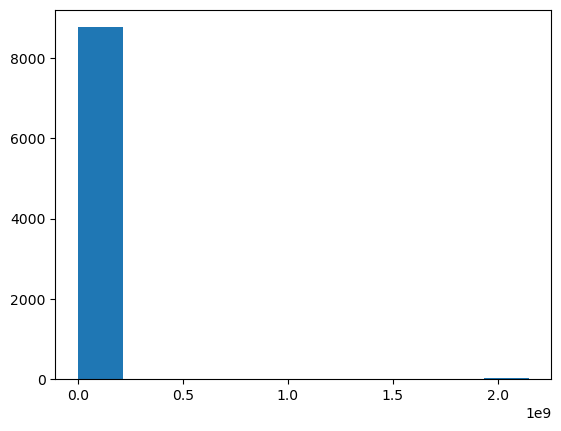

In [67]:
# understand the key metrics
plt.hist(df_nj['ptc_15d'])

(array([7.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.100e+01, 0.000e+00, 0.000e+00, 0.000e+00,
        5.000e+00, 0.000e+00, 4.100e+01, 0.000e+00, 4.000e+00, 0.000e+00,
        6.200e+01, 0.000e+00, 3.100e+01, 5.000e+01, 4.100e+01, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 8.648e+03]),
 array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
         22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
         45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
         67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
         90. ,  92.5,  95. ,  97.5, 100. ]),
 <BarContainer object of 40 artists>)

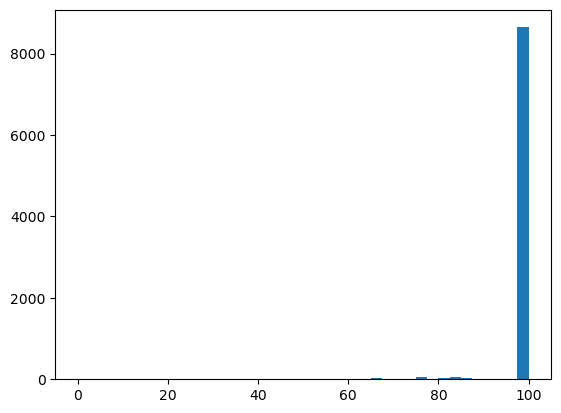

In [69]:
# plt.hist(df['detect_prop_15d'], bins= [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.hist(df_nj['detect_prop_15d'], bins=40)

(array([ 242.,  807., 1044., 1215., 1139., 1144.,  967.,  950.,  876.,
         498.]),
 array([ 0.  ,  9.78, 19.56, 29.34, 39.12, 48.9 , 58.68, 68.46, 78.24,
        88.02, 97.8 ]),
 <BarContainer object of 10 artists>)

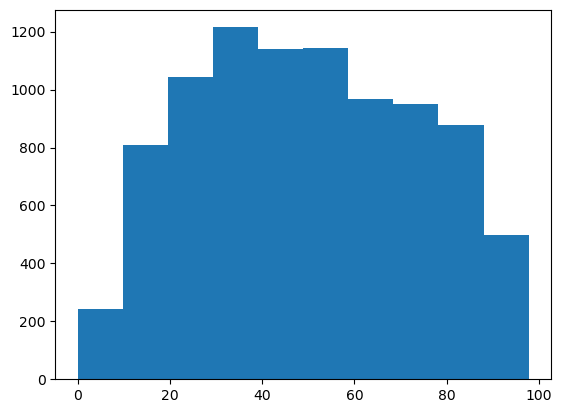

In [70]:
# plt.hist(df['percentile'], bins= [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.hist(df_nj['percentile'])

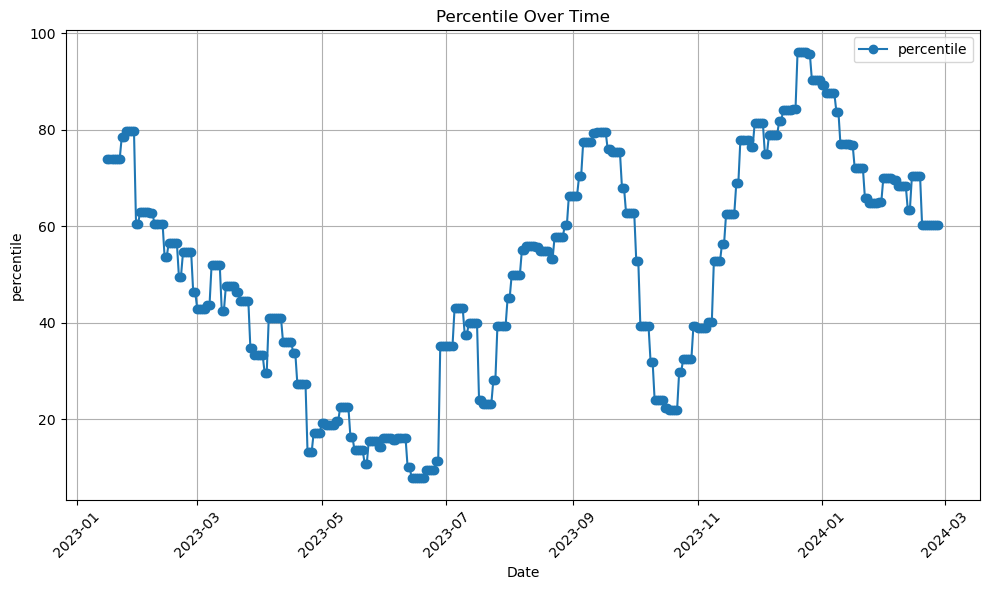

In [81]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(df_mx['date_start'], df_mx['percentile'], label='percentile', marker='o')
# plt.plot(df_mx['date_start'], np.log(df_mx['ptc_15d']), label='ptc_15d', marker='x')
# plt.plot(df_mx['date_start'], df_mx['detect_prop_15d'], label='detect_prop_15d', marker='x')

plt.title('Percentile Over Time')
plt.xlabel('Date')
plt.ylabel('percentile')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.grid(True)
plt.tight_layout()

plt.show()

In [84]:
# # Plotting
# plt.figure(figsize=(10, 6))

# plt.plot(df_mx['date_start'], df_mx['percentile'], label='percentile', marker='o')
# plt.plot(df_mx['date_start'], df_mx['log_ptc_15d'], label='log_ptc_15d', marker='x')

# plt.title('Metrics Over Time')
# plt.xlabel('Date')
# plt.ylabel('Value')
# plt.legend()

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# plt.grid(True)
# plt.tight_layout()

# plt.show()

In [88]:
df_nj.sample(10)

,wwtp_jurisdiction,wwtp_id,reporting_jurisdiction,sample_location,sample_location_specify,key_plot_id,county_names,county_fips,population_served,date_start,date_end,ptc_15d,detect_prop_15d,percentile,sampling_prior,first_sample_date,county_group
150216,New Jersey,1453,New Jersey,Treatment plant,NaN,NWSS_nj_1453_Treatment plant_raw wastewater,Monmouth,34025,47000,2023-11-27,2023-12-11,26.0,100.0,71.250,no,2023-02-01,other
108730,New Jersey,2356,New Jersey,Treatment plant,NaN,NWSS_nj_2356_Treatment plant_raw wastewater,Hudson,34017,22181,2023-08-31,2023-09-14,-12.0,100.0,47.200,no,2023-06-21,other
10238,New Jersey,2222,New Jersey,Treatment plant,NaN,WWS_nj_2222_Treatment plant_primary sludge,Monmouth,34025,100000,2023-07-27,2023-08-10,10.0,100.0,35.857,no,2023-04-28,other
421785,New Jersey,1322,New Jersey,Treatment plant,NaN,NWSS_nj_1322_Treatment plant_raw wastewater,"Essex,Union","34039,34013",1300000,2023-11-09,2023-11-23,50.0,100.0,41.000,no,2023-02-07,other
505126,New Jersey,1605,New Jersey,Treatment plant,NaN,NWSS_nj_1605_Treatment plant_raw wastewater,Bergen,34003,564563,2023-12-23,2024-01-06,-41.0,100.0,96.600,no,2023-01-30,other
205719,New Jersey,2378,New Jersey,Treatment plant,NaN,NWSS_nj_2378_Treatment plant_raw wastewater,Sussex,34037,7751,2023-10-10,2023-10-24,399.0,100.0,25.800,no,2023-08-09,other
383315,New Jersey,1616,New Jersey,Treatment plant,NaN,NWSS_nj_1616_Treatment plant_post grit removal,Monmouth,34025,40000,2023-08-04,2023-08-18,NaN,NaN,NaN,no,2023-01-31,other
446889,New Jersey,1907,New Jersey,Treatment plant,NaN,WWS_nj_1907_Treatment plant_primary sludge,Monmouth,34025,52672,2023-05-08,2023-05-22,-4.0,100.0,9.000,no,2022-12-05,other
456329,New Jersey,2349,New Jersey,Treatment plant,NaN,NWSS_nj_2349_Treatment plant_raw wastewater,Atlantic,34001,12000,2023-10-17,2023-10-31,820.0,100.0,51.000,no,2023-07-13,other
618768,New Jersey,2209,New Jersey,Treatment plant,NaN,WWS_nj_2209_Treatment plant_post grit removal,Monmouth,34025,50000,2023-06-27,2023-07-11,3.0,100.0,19.750,no,2023-04-11,other


In [93]:
top_population_county = df_nj.groupby('county_names', as_index=0)[['population_served']].mean().sort_values('population_served', ascending=False)
top_population_county

# Function to determine county_top_5
def determine_county(population, county_name):
    if population > 500000:
        return county_name
    else:
        return 'other'

# Applying the function to create county_top_5 column
df_nj['county_top_5'] = df_nj.apply(lambda row: determine_county(row['population_served'], row['county_names']), axis=1)

df_nj.sample(10)


,wwtp_jurisdiction,wwtp_id,reporting_jurisdiction,sample_location,sample_location_specify,key_plot_id,county_names,county_fips,population_served,date_start,date_end,ptc_15d,detect_prop_15d,percentile,sampling_prior,first_sample_date,county_group,county_top_5
200275,New Jersey,2107,New Jersey,Treatment plant,NaN,WWS_nj_2107_Treatment plant_post grit removal,Cumberland,34011,50000,2023-09-22,2023-10-06,-7.0,100.0,58.000,no,2023-03-13,other,other
505125,New Jersey,1605,New Jersey,Treatment plant,NaN,NWSS_nj_1605_Treatment plant_raw wastewater,Bergen,34003,564563,2023-12-22,2024-01-05,-41.0,100.0,96.600,no,2023-01-30,other,Bergen
421857,New Jersey,1322,New Jersey,Treatment plant,NaN,NWSS_nj_1322_Treatment plant_raw wastewater,"Essex,Union","34039,34013",1300000,2024-01-20,2024-02-03,-5.0,100.0,79.400,no,2023-02-07,other,"Essex,Union"
504874,New Jersey,1605,New Jersey,Treatment plant,NaN,NWSS_nj_1605_Treatment plant_raw wastewater,Bergen,34003,564563,2023-04-15,2023-04-29,33.0,100.0,28.000,no,2023-01-30,other,Bergen
200370,New Jersey,2107,New Jersey,Treatment plant,NaN,WWS_nj_2107_Treatment plant_post grit removal,Cumberland,34011,50000,2023-12-26,2024-01-09,12.0,100.0,72.800,no,2023-03-13,other,other
505338,New Jersey,2107,New Jersey,Treatment plant,NaN,NWSS_nj_2107_Treatment plant_raw wastewater,Cumberland,34011,30000,2023-07-18,2023-08-01,-60.0,80.0,35.600,no,2023-03-09,other,other
150173,New Jersey,1453,New Jersey,Treatment plant,NaN,NWSS_nj_1453_Treatment plant_raw wastewater,Monmouth,34025,47000,2023-10-15,2023-10-29,-32.0,100.0,36.800,no,2023-02-01,other,other
421596,New Jersey,1322,New Jersey,Treatment plant,NaN,NWSS_nj_1322_Treatment plant_raw wastewater,"Essex,Union","34039,34013",1300000,2023-05-04,2023-05-18,22.0,100.0,31.000,no,2023-02-07,other,"Essex,Union"
511777,New Jersey,2400,New Jersey,Treatment plant,NaN,NWSS_nj_2400_Treatment plant_raw wastewater,Salem,34033,5500,2023-10-08,2023-10-22,340.0,100.0,28.333,no,2023-08-29,other,other
366209,New Jersey,1385,New Jersey,Treatment plant,NaN,NWSS_nj_1385_Treatment plant_raw wastewater,Hudson,34017,145000,2023-05-26,2023-06-09,-29.0,100.0,26.800,no,2023-01-30,other,other


In [85]:
top_pct_county = df_nj.groupby('county_names', as_index=0)[['percentile']].mean().sort_values('percentile', ascending=False)

top_5 = top_pct_county.head()['county_names']

print(top_5)

# Create a new column 'county' where only top 5 counties are named, the rest are labeled as 'other'
df_nj['county_group'] = df['county_names'].apply(lambda x: x if x in top_5 else 'other')

df_nj.head(30)



1                          Bergen
4     Essex,Hudson,Passaic,Bergen
12                        Passaic
6                     Essex,Union
8                       Hunterdon
Name: county_names, dtype: object


,wwtp_jurisdiction,wwtp_id,reporting_jurisdiction,sample_location,sample_location_specify,key_plot_id,county_names,county_fips,population_served,date_start,date_end,ptc_15d,detect_prop_15d,percentile,sampling_prior,first_sample_date,county_group
568274,New Jersey,788,New Jersey,Treatment plant,NaN,WWS_nj_788_Treatment plant_primary sludge,"Essex,Hudson,Union,Passaic,Bergen","34003,34039,34013,34031,34017",1500000,2023-01-01,2023-01-15,-9.0,100.0,86.000,no,2022-08-05,other
446762,New Jersey,1907,New Jersey,Treatment plant,NaN,WWS_nj_1907_Treatment plant_primary sludge,Monmouth,34025,52672,2023-01-01,2023-01-15,-14.0,100.0,79.333,no,2022-12-05,other
446763,New Jersey,1907,New Jersey,Treatment plant,NaN,WWS_nj_1907_Treatment plant_primary sludge,Monmouth,34025,52672,2023-01-02,2023-01-16,-14.0,100.0,79.333,no,2022-12-05,other
568275,New Jersey,788,New Jersey,Treatment plant,NaN,WWS_nj_788_Treatment plant_primary sludge,"Essex,Hudson,Union,Passaic,Bergen","34003,34039,34013,34031,34017",1500000,2023-01-02,2023-01-16,-9.0,100.0,86.000,no,2022-08-05,other
446764,New Jersey,1907,New Jersey,Treatment plant,NaN,WWS_nj_1907_Treatment plant_primary sludge,Monmouth,34025,52672,2023-01-03,2023-01-17,-10.0,100.0,78.714,no,2022-12-05,other
568276,New Jersey,788,New Jersey,Treatment plant,NaN,WWS_nj_788_Treatment plant_primary sludge,"Essex,Hudson,Union,Passaic,Bergen","34003,34039,34013,34031,34017",1500000,2023-01-03,2023-01-17,-9.0,100.0,86.000,no,2022-08-05,other
568277,New Jersey,788,New Jersey,Treatment plant,NaN,WWS_nj_788_Treatment plant_primary sludge,"Essex,Hudson,Union,Passaic,Bergen","34003,34039,34013,34031,34017",1500000,2023-01-04,2023-01-18,-26.0,100.0,76.500,no,2022-08-05,other
446765,New Jersey,1907,New Jersey,Treatment plant,NaN,WWS_nj_1907_Treatment plant_primary sludge,Monmouth,34025,52672,2023-01-04,2023-01-18,-3.0,100.0,76.857,no,2022-12-05,other
446766,New Jersey,1907,New Jersey,Treatment plant,NaN,WWS_nj_1907_Treatment plant_primary sludge,Monmouth,34025,52672,2023-01-05,2023-01-19,-1.0,100.0,76.857,no,2022-12-05,other
568278,New Jersey,788,New Jersey,Treatment plant,NaN,WWS_nj_788_Treatment plant_primary sludge,"Essex,Hudson,Union,Passaic,Bergen","34003,34039,34013,34031,34017",1500000,2023-01-05,2023-01-19,-16.0,100.0,78.714,no,2022-08-05,other


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


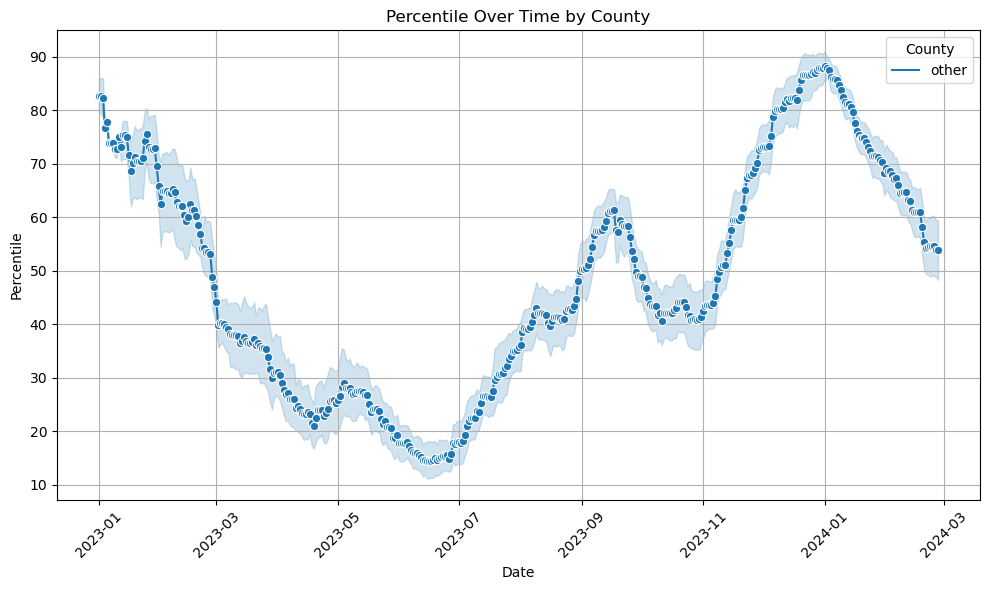

In [54]:
# bring ing multiple county and only look at percentiles

# Plotting with Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_nj, x='date_start', y='percentile', hue='county_group', marker='o')

plt.title('Percentile Over Time by County')
plt.xlabel('Date')
plt.ylabel('Percentile')
plt.legend(title='County')

plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

plt.show()